### Imports

In [1]:
from MRI_dataset import MRIdataset_all_dims_hdf5
from other import *
from torch.utils.data import DataLoader
from Unet import Unet
import torch
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler
import time
from matplotlib import pyplot as plt
import numpy as np
from ConbinedLoss import CombinedLoss
from ipywidgets import interact, IntSlider, ToggleButtons, fixed

### Datasets & Dataloaders

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MRIdataset_all_dims_hdf5(hdf5_path='train_MRI_dataset_cleaned_2.h5', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

test_dataset = MRIdataset_all_dims_hdf5(hdf5_path='test_MRI_dataset_cleaned_2.h5', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

Dataset loaded. Total slices: 10766
Dataset loaded. Total slices: 3276


### Model & Training parameters

In [5]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 20
LRate = 1e-4

depth = 3
k_size = 3
base_channels = 64

model = Unet(in_channels=1, num_features=1, depth=depth, k_size=k_size, base_channels=base_channels).to(device)

criterion = CombinedLoss() #  nn.BCEWithLogitsLoss() # DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LRate, weight_decay=1e-5)# torch.optim.SGD(model.parameters(), lr=LRate, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer,mode='min', factor=0.5, patience = 3)

### Training and validation loop

In [7]:
# The image mask we want to track to visualize the training process
track_img_mask = []

data_path, roi_path = get_patient_file_paths(1)

data_volume = load_nii(data_path).astype(np.float32) if data_path else ValueError("Data path is None")
roi_volume = load_nii(roi_path).astype(np.float32) if roi_path else ValueError("ROI path is None")

track_data_slice = data_volume[111, :, :]

track_img_mask.append(pad_slice_to_target_shape(roi_volume[111, :, :]))

print(track_data_slice.shape)
# plt.imshow(track_img_mask[0])

(256, 256)


In [ ]:
from torch.amp import autocast, GradScaler

scaler = GradScaler("cuda")

train_losses = []
val_losses = []

epoch_train_iou = []
epoch_val_iou = []

epoch_train_losses = []
epoch_val_losses = []

train_times = []
val_times = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    avg_loss = 0.0
    avg_val_loss = 0.0
    running_train_iou = 0.0
    running_val_iou = 0.0
    start = time.time()

    # Training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=False)
    for i, (data_slice, roi_slice) in enumerate(progress_bar):
        data_slice = data_slice.to(device)
        roi_slice = roi_slice.to(device)

        optimizer.zero_grad()

        with autocast("cuda"):
          outputs = model(data_slice)
          loss = criterion(outputs, roi_slice)

        train_losses.append(loss.item())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update progress
        running_loss += loss.item()

        # Compute IoU for this batch:
        # Threshold predictions at 0.5 to obtain binary mask
        preds = (outputs > 0.5).float()
        # Squeeze channel dimension so shape becomes [batch, H, W]
        preds_np = preds.squeeze(1).cpu().numpy()
        truth_np = roi_slice.squeeze(1).cpu().numpy()

        # Compute IoU for each sample in the batch
        batch_iou = []
        for pred_mask, truth_mask in zip(preds_np, truth_np):
            # Use the iou_score function from metrics.py
            batch_iou.append(iou_score(truth_mask, pred_mask))
        running_train_iou += np.mean(batch_iou)

        progress_bar.set_postfix({'Batch Loss': loss.item(), 'Batch IoU': np.mean(batch_iou)})

    progress_bar.close()

    # Average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    avg_train_iou = running_train_iou / len(train_loader)
    epoch_train_losses.append(avg_loss)
    epoch_train_iou.append(avg_train_iou)
    train_times.append(time.time() - start)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Training Loss: {avg_loss:.4f}, Train IoU: {avg_train_iou:.4f}, Time: {train_times[-1]:.2f}s")

    # Validation
    model.eval()
    with torch.no_grad():

        val_loss = 0.0
        start = time.time()
        val_progress_bar = tqdm(test_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=False)

        for i, (data_slice, roi_slice) in enumerate(val_progress_bar):
            data_slice = data_slice.to(device)
            roi_slice = roi_slice.to(device)

            with autocast("cuda"):
              outputs = model(data_slice)
              loss = criterion(outputs, roi_slice)

            val_loss += loss.item()
            val_losses.append(loss.item())

            # Compute IoU for validation batch
            preds = (outputs > 0.5).float()
            preds_np = preds.squeeze(1).cpu().numpy()
            truth_np = roi_slice.squeeze(1).cpu().numpy()

            batch_iou = []
            for pred_mask, truth_mask in zip(preds_np, truth_np):
                batch_iou.append(iou_score(truth_mask, pred_mask))
            running_val_iou += np.mean(batch_iou)

            val_progress_bar.set_postfix({'Batch Loss': loss.item(), 'Batch IoU': np.mean(batch_iou)})
        val_progress_bar.close()

        track_data_slice_tensor = torch.tensor(track_data_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        outputs = model(track_data_slice_tensor.to(device))
        track_img_mask.append(pad_slice_to_target_shape(outputs.squeeze().cpu().detach().numpy()))

        avg_val_loss = val_loss / len(test_loader)
        avg_val_iou = running_val_iou / len(test_loader)
        epoch_val_losses.append(avg_val_loss)
        epoch_val_iou.append(avg_val_iou)
        val_times.append(time.time() - start)
    
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Validation Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}, Time: {val_times[-1]:.2f}s")

print("Training finished")


total = sum(train_times) + sum(val_times)
hours, rem = divmod(total, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total computation time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

print(f"Training time: {sum(train_times):.2f}s")
print(f"Validation time: {sum(val_times):.2f}s")

In [ ]:
model.eval()

# torch.save(model.state_dict(), 'MRI_segmentation_model.pth')
torch.save(model, f'Unet_e{EPOCHS}_d{depth}_k{k_size}_bc{base_channels}.pth')

### Visualisation

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 5))
plt.plot(epoch, epoch_train_losses, label='Training Loss')
plt.plot(epoch, epoch_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

plt.savefig(f'loss_plot_e{EPOCHS}_d{depth}_k{k_size}_bc{base_channels}.png')

In [ ]:
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, epoch_train_iou, label='Train IoU')
plt.plot(epochs, epoch_val_iou, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.title('IoU Score over Epochs')
plt.legend()
plt.show()

In [ ]:
import ipywidgets as widgets

def plot_roi_mask(slice_index):
    plt.figure(figsize=(5, 5))
    plt.imshow(track_img_mask[slice_index], cmap='autumn')
    plt.title(f'ROI Mask - Epoch {slice_index}')
    plt.show()

slice_slider = widgets.IntSlider(min=0, max=len(track_img_mask) -1, step=1, value=0, description='Epoch:')

widgets.interact(plot_roi_mask, slice_index=slice_slider)

In [ ]:
def visualize_results(model, dataset, num_samples=6, is_training=True):
    """
    Visualize model predictions against ground truth for the first num_samples images
    
    Args:
        model: trained model
        dataset: dataset to sample from
        num_samples: number of images to visualize
        is_training: whether this is training or test dataset
    """
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    dataset_type = "Training" if is_training else "Test"
    
    # Set the figure title
    fig.suptitle(f'{dataset_type} Dataset: Original vs Ground Truth vs Prediction', fontsize=16)
    
    # Column titles
    axes[0, 0].set_title('Original MRI')
    axes[0, 1].set_title('Ground Truth')
    axes[0, 2].set_title('Model Prediction')
    
    for i in range(min(num_samples, len(dataset))):
        # Get image and mask from dataset
        img, mask = dataset[i]
        
        # Make sure image is in the right format for the model
        if isinstance(img, np.ndarray):
            # Convert to tensor if needed
            x = torch.from_numpy(img).unsqueeze(0)  # Add batch dimension
        else:
            x = img.unsqueeze(0)  # Add batch dimension
        
        # Get prediction
        with torch.no_grad():
            pred = model(x.to(device))

            pred = pred.squeeze().sigmoid().to('cpu').detach().numpy()
            treshold = 0.1
            pred = pred > treshold

            # pred = torch.sigmoid(pred).cpu() > 0.5
            # pred = pred.squeeze().numpy().astype(np.float32)
        
        # Convert tensors to numpy for visualization
        if not isinstance(img, np.ndarray):
            img = img.squeeze().cpu().numpy()
        
        if not isinstance(mask, np.ndarray):
            mask = mask.squeeze().cpu().numpy()
        
            
        # Display the images
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 1].imshow(mask, cmap='viridis')
        axes[i, 2].imshow(pred, cmap='viridis')
        
        # Remove axis ticks
        for j in range(3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the title
    plt.show()

In [3]:
model = torch.load("results/Unet_e5_d3_k3_c64.pth", map_location=device)
model.eval()
visualize_results(model, test_dataset, num_samples=5, is_training=False)
visualize_results(model, train_dataset, num_samples=5, is_training=True)

C:\Users\marte\AppData\Local\Temp\ipykernel_22896\648241597.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("results/Unet_e5_d3_k3_c64.pth", map_locat

NameError: name 'visualize_results' is not defined

In [ ]:
def test_random_image(model, test_dataset, device):
    import random
    import matplotlib.pyplot as plt

    model.eval()
    random_idx = random.randint(0, len(test_dataset) - 1)
    image, mask = test_dataset[random_idx]

    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(image)
        # print(pred_mask)
        pred_mask = pred_mask.squeeze().sigmoid().to('cpu').detach().numpy()
        # print(pred_mask)
        treshold = 0.5 # 2*pred_mask.mean() + 2*pred_mask.std()
        #fig, ax = skimage.filters.try_all_threshold(pred_mask, figsize=(10, 5), verbose=False)
        pred_mask = pred_mask > treshold
    
    # pred_mask = pred_mask.squeeze().to('cpu').detach().numpy()
    image = image.squeeze().to('cpu').detach().numpy()
    mask = mask.squeeze().to('cpu').detach().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(image.T, cmap='gray')
    ax[0].imshow(mask.T, cmap='autumn', alpha=0.5)
   # ax[1].imshow(image.T, cmap='gray')
    ax[1].imshow(pred_mask.T, cmap='autumn')

   # plt.figure(figsize=(15, 5))
   # plt.imshow(image.T, cmap='gray')
   # plt.imshow(mask.T, cmap='cool', alpha=0.5)
   # plt.imshow(pred_mask.T, cmap='autumn', alpha=0.6)

    plt.show()

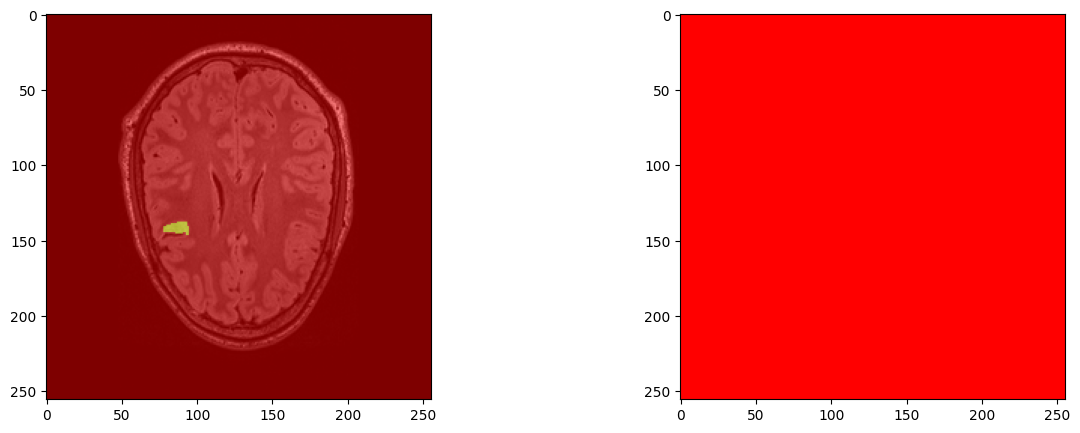

In [15]:
test_random_image(model, train_dataset, device)

### Read the model and calculate : precision, recall, dice coefficient and Jaccar Index.

In [6]:
from metrics import precision_score_, recall_score_, dice_coef, iou_score

model = torch.load("results/Unet_e20_d4_k5_c64.pth", map_location=device)
model.eval()

C:\Users\marte\AppData\Local\Temp\ipykernel_24652\2994917422.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("results/Unet_e20_d4_k5_c64.pth", map_loc

Unet(
  (down_layers): ModuleList(
    (0): DownSample(
      (conv): DoubleConv(
        (double_conv_op): Sequential(
          (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownSample(
      (conv): DoubleConv(
        (double_conv_op): Sequential(
          (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3),

In [ ]:
model.eval()

all_precisions = []
all_recalls = []
all_dice = []
all_iou = []

with torch.no_grad():
    for data_slice, roi_slice in tqdm(test_loader, desc="Testing"):
        data_slice = data_slice.to(device)
        roi_slice = roi_slice.to(device)
        
        outputs = model(data_slice)
        
        # Squeeze the channel dimension and move to CPU
        # outputs_np and roi_np will have shape [batch, H, W]
        outputs = torch.sigmoid(outputs)
        outputs_np = outputs.squeeze(1).cpu().numpy()
        roi_np = roi_slice.squeeze(1).cpu().numpy()
        
        # Threshold outputs to obtain binary masks
        preds_np = (outputs_np > 0.5).astype(np.float32)
        
        # Iterate over the batch samples and compute metrics for each slice
        for pred_mask, truth_mask in zip(preds_np, roi_np):
            precision = precision_score_(truth_mask, pred_mask)
            recall = recall_score_(truth_mask, pred_mask)
            dice = dice_coef(truth_mask, pred_mask)
            iou = iou_score(truth_mask, pred_mask)
            
            all_precisions.append(precision)
            all_recalls.append(recall)
            all_dice.append(dice)
            all_iou.append(iou)

avg_precision = np.mean(all_precisions)
avg_recall = np.mean(all_recalls)
avg_dice = np.mean(all_dice)
avg_iou = np.mean(all_iou)

print(f"Average Precision: {avg_precision:.3f}")
print(f"Average Recall: {avg_recall:.3f}")
print(f"Average Dice Coefficient: {avg_dice:.3f}")
print(f"Average IoU Score: {avg_iou:.3f}")

Testing:   0%|          | 0/103 [00:00<?, ?it/s]

Average Precision: 0.824
Average Recall: 0.824
Average Dice Coefficient: 0.824
Average IoU Score: 0.824


In [2]:
import h5py
import numpy as np

def calculate_roi_vs_brain(hdf5_path, roi_threshold=0, brain_threshold=0):
    """
    Calculates the repartition of slices with and without ROI and computes the percentage of ROI 
    relative to both the full slice area and the brain area in each slice.
    
    Args:
        hdf5_path (str): Path to the HDF5 file. The file must contain datasets 'data' and 'roi'.
        roi_threshold (float): Threshold to consider a pixel in the ROI mask as positive.
        brain_threshold (float): Threshold to determine the brain area in the MRI data.
        
    Returns:
        dict: A dictionary containing:
            - total_slices: Total number of slices.
            - with_roi: Number of slices with ROI.
            - without_roi: Number of slices without ROI.
            - pct_with_roi: Percentage of slices with ROI.
            - pct_without_roi: Percentage of slices without ROI.
            - avg_roi_percent_over_slice: Average percentage of the entire slice area occupied by the ROI.
            - avg_roi_percent_over_brain: Average percentage of the brain area (as defined by MRI data) occupied by the ROI (computed only for slices with brain area > 0).
    """
    # Load both datasets from the HDF5 file
    with h5py.File(hdf5_path, 'r') as hf:
        mri_data = hf['data'][:]  # Expected shape: (num_slices, H, W)
        roi_data = hf['roi'][:]   # Expected shape: (num_slices, H, W)
    
    total_slices = mri_data.shape[0]
    
    # Determine which slices have ROI by checking if the sum of positive pixels in ROI is > 0.
    roi_area = [roi for roi in np.sum(roi_data > roi_threshold, axis=(1,2)) if roi > 0]
    roi_presence = [roi > 0 for roi in np.sum(roi_data > roi_threshold, axis=(1,2))]
    with_roi_count = len(roi_area)
    without_roi_count = total_slices - with_roi_count
    
    # Calculate ROI percentage relative to the entire slice area.
    slice_area = mri_data.shape[1] * mri_data.shape[2]
    roi_percentage_over_slice = np.array([(area / slice_area) * 100.0 for area in roi_area])
    
    # Estimate the brain area for each slice from the MRI data.
    # Here, we assume that pixels in the MRI image above brain_threshold belong to the brain.
    brain_mask = mri_data > brain_threshold
    brain_areas = np.sum(brain_mask, axis=(1,2))
    
    # For each slice, compute ROI percentage relative to the brain area.
    roi_percentage_over_brain = []
    for i in range(total_slices):
        if brain_areas[i] > 0 and roi_presence[i]:
            roi_percentage_over_brain.append((np.sum(roi_data[i] > roi_threshold) / brain_areas[i]) * 100)
    roi_percentage_over_brain = np.array(roi_percentage_over_brain)
    
    repartition = {
        'total_slices': int(total_slices),
        'with_roi': int(with_roi_count),
        'without_roi': int(without_roi_count),
        'pct_with_roi': with_roi_count / total_slices * 100,
        'pct_without_roi': without_roi_count / total_slices * 100,
        'avg_roi_percent_over_slice': round(np.mean(roi_percentage_over_slice), 3),
        'avg_roi_percent_over_brain': round(np.mean(roi_percentage_over_brain), 3),
        'max_roi_percent_over_brain': round(np.max(roi_percentage_over_brain), 3),
        'min_roi_percent_over_brain': round(np.min(roi_percentage_over_brain), 3)
    }
    
    return repartition

# stats_test = calculate_roi_vs_brain('test_MRI_dataset_cleaned_2.h5', roi_threshold=0, brain_threshold=0)
stats_train = calculate_roi_vs_brain('MSLesSeg-Dataset/train_data.h5', roi_threshold=0, brain_threshold=0)
# print(stats_test)
print(stats_train)

{'total_slices': 24486, 'with_roi': 14681, 'without_roi': 9805, 'pct_with_roi': 59.95670995670995, 'pct_without_roi': 40.04329004329004, 'avg_roi_percent_over_slice': 0.446, 'avg_roi_percent_over_brain': 1.389, 'max_roi_percent_over_brain': 6.668, 'min_roi_percent_over_brain': 0.008}


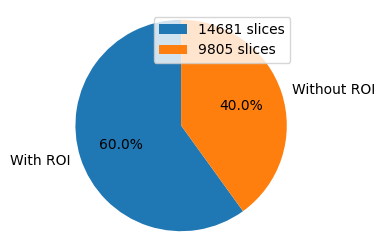

In [4]:
from matplotlib import pyplot as plt

def plot_roi_repartition(stats,):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.pie([stats['with_roi'], stats['without_roi']], labels=['With ROI', 'Without ROI'], autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.legend([f'{stats["with_roi"]} slices', f'{stats["without_roi"]} slices'], loc='upper right')
    plt.show()

# Test Dataset: Repartition of Slices with and without ROI
plot_roi_repartition(stats_train)

In [20]:
def plot_patient_MRI():    
    def plot_explore_slices(num_patient, axes): 
        file_paths = [f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-T2sel_FLAIR.nii.gz',
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-tse3dvfl_FLAIR.nii.gz',
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-corhipp4mm_FLAIR.nii.gz', # remove (18)
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-traAcpc4mm_FLAIR.nii.gz', # remove (27)
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-traacpcVNS_FLAIR.nii.gz', # remove (53)
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-32ch10_FLAIR.nii.gz',
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-cor3mmOPT_FLAIR.nii.gz',
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-tra4mm_FLAIR.nii.gz', # remove (112)
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-corAcpc4mm_FLAIR.nii.gz', # remove (120)
                        f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-cor4mm_FLAIR.nii.gz' # remove (130)
                        ]
           
        roi_paths = [f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-T2sel_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-tse3dvfl_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-corhipp4mm_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-traAcpc4mm_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-traacpcVNS_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-32ch10_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-cor3mmOPT_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-tra4mm_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-corAcpc4mm_FLAIR_roi.nii.gz',
                    f'OpenNeuro_ds004199/sub-00{num_patient:03d}/anat/sub-00{num_patient:03d}_acq-cor4mm_FLAIR_roi.nii.gz'
                    ]
        
        for i in range(len(file_paths)):
            if not os.path.exists(file_paths[i]):
                continue
            file_path = file_paths[i]
            roi_path = roi_paths[i]
            if not os.path.exists(roi_paths[i]):
                roi_path = None
            break
         
        img_tensor = torch.tensor(load_nii(file_path), dtype=torch.float32)
        if roi_path is not None:
            roi_tensor = torch.tensor(load_nii(roi_path), dtype=torch.float32)
        else:
            roi_tensor = None

        def explore_slices(layer):
            
            fig, ax = plt.subplots(1, 2, figsize=(10, 5)) 
            ax[0].grid(False)
            ax[1].grid(False)

            model = torch.load("results/Unet_dice70+BCE30_e20_d3_k3_c64_newdataset.pth", map_location=device)
            model.eval()
            
            if axes == 0:
                img_slice = img_tensor[layer, :, :].unsqueeze(0).unsqueeze(0)
                with torch.no_grad():
                    pred_mask = model(img_slice.to(device))
                    pred_mask = pred_mask.squeeze().sigmoid().to('cpu').detach().numpy()
                    pred_mask = pred_mask > 0.5
                ax[0].imshow(img_tensor[layer, :, :].T, cmap="gray", origin="lower")
                ax[0].imshow(pred_mask.T, cmap="autumn", alpha=0.4, origin="lower")
                if roi_tensor is not None:
                    ax[1].imshow(img_tensor[layer, :, :], cmap="gray", origin="lower")
                    ax[1].imshow(roi_tensor[layer, :, :], cmap="autumn", alpha=0.5)

            elif axes == 1:
                img_slice = img_tensor[:, layer, :]
                img_slice_tensor = img_slice.unsqueeze(0).unsqueeze(0)
                with torch.no_grad():
                    pred_mask = model(img_slice_tensor.to(device))
                    pred_mask = pred_mask.squeeze().sigmoid().to('cpu').detach().numpy()
                    pred_mask = pred_mask > 0.5
                ax[0].imshow(img_tensor[:, layer, :].T, cmap="gray", origin="lower")
                ax[0].imshow(pred_mask.T, cmap="autumn", alpha=0.4, origin="lower")
                if roi_tensor is not None:
                    ax[1].imshow(img_tensor[:, layer, :], cmap="gray", origin="lower")
                    ax[1].imshow(roi_tensor[:, layer, :], cmap="autumn", alpha=0.4, origin="lower")

            elif axes == 2:
                img_slice = img_tensor[:, :, layer]
                img_slice_tensor = img_slice.unsqueeze(0).unsqueeze(0)
                with torch.no_grad():
                    pred_mask = model(img_slice_tensor.to(device))
                    pred_mask = pred_mask.squeeze().sigmoid().to('cpu').detach().numpy()
                    pred_mask = pred_mask > 0.5
                ax[0].imshow(img_tensor[:, :, layer].T, cmap="gray", origin="lower")
                ax[0].imshow(pred_mask.T, cmap="autumn", alpha=0.4, origin="lower")
                if roi_tensor is not None:
                    ax[1].imshow(img_tensor[:, :, layer].T, cmap="gray", origin="lower")
                    ax[1].imshow(roi_tensor[:, :, layer].T, cmap="autumn",alpha=0.4, origin="lower")
            else:
                raise ValueError("Invalid axes value. Choose between 'Sagittal', 'Coronal', 'Axial'")
            
            return layer 

        interact(explore_slices, num_patient=IntSlider(value=1, min=1, max=170, description='Subject num_patientber'), layer=(0, img_tensor.shape[axes] - 1))
    
    interact(plot_explore_slices, num_patient=[i for i in range(1, 171)], axes=ToggleButtons(
        options=[0, 1, 2],
        description='Axes:',
        button_style='info',
        tooltips=['Sagittal', 'Coronal', 'Axial'],
    ))

In [21]:
plot_patient_MRI()

interactive(children=(Dropdown(description='num_patient', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …